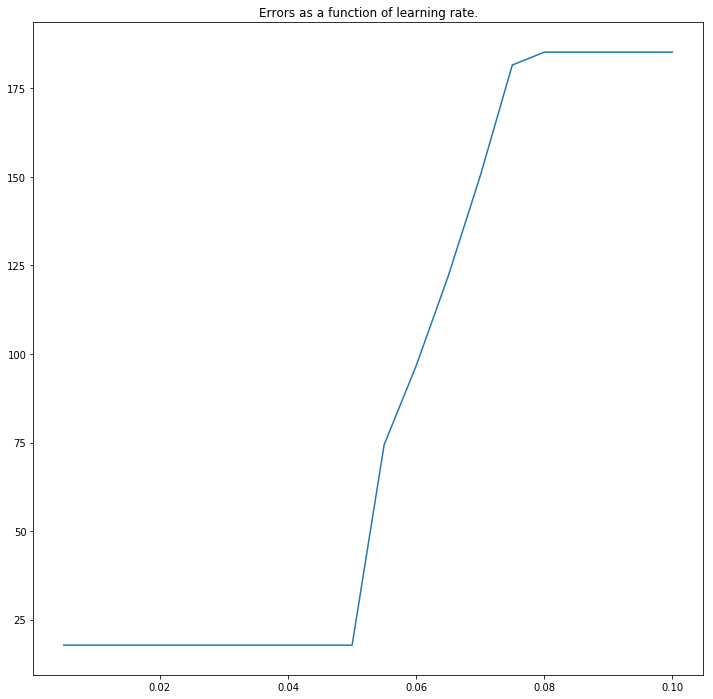

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

def graph_denoising(noisy, measure_estimates, epsilon, learning_rate, max_iterations):
    t = 0
    # print(np.shape(noisy))
    W = noisy
    W_0 = noisy - 1
    # print(graph_measures(W))
    E = np.sum(np.power(np.subtract(graph_measures(W), measure_estimates), 2))
    # print(graph_measures(W) - measure_estimates)
    #print(E)
    while E > epsilon and t < max_iterations and ((W - W_0) != 0).any():
        measures = graph_measures(W)
        # print("shape of measures " + str(np.shape(measures)))
        measure_derivatives = graph_measure_derivatives(W)
        # print("shape of derivatives " +str(np.shape(measure_derivatives)))
        #print(len(measure_estimates))
        #print(len(measures))
        # print(measures[0])
        # print(measure_derivatives[0])
        measures_minus_estimates_times_derivatives = [
            np.dot((measures[i] - measure_estimates[i]), measure_derivatives[i]) for i in range(len(measure_estimates))
        ]
        # print(measures_minus_estimates_times_derivatives)
        # print(np.shape(measures_minus_estimates_times_derivatives))
        # print(np.shape(np.sum(measures_minus_estimates_times_derivatives, axis=0)))
        W_0 = W
        W = W - learning_rate * np.sum(measures_minus_estimates_times_derivatives, axis=0)
        # print(np.shape(W))
        W[W < 0] = 0
        W[W > 1] = 1
        E = np.sum(np.power((graph_measures(W) - measure_estimates), 2))
        # print(E)
        t = t + 1
        if t >= max_iterations:
            print("The algorithm stopped because of reaching max iterations. Error at the end was " + str(E)+ ".")
        if (W - W_0 == 0).all():
            print("The algorithm has stopped after " + str(t) + " iterations, beacause, the resulting "
                                                                "matrix stopped changing."
                                                                " Error at the end was " + str(E)+".")
    return W, t, E

def graph_measures(W):
    # Fill the graph measures here
    # return a list of length n, where n is the number of measures we are using
    measures = []
    for i in range(len(W)):
        measures.append(distance_measure(W, i))

    return np.array(measures)

def distance_measure(W, i):
    return np.sum(W, axis=1)[i] # = [1,2,3,4,5,6,7][i]


def graph_measure_derivatives(W):
    # Fill the graph measure derivatives here
    # return something with the shape of (W,n) where n is the number of measures we are using
    return np.array([np.ones(np.shape(W)) for i in range(len(W))])

##### determinig the W_d.
filename_info = 'C:/MyTemp/ECMI_Data/dt/AlpArray/METRICS/2016366_local_pair_dist.txt'

distances = np.zeros((7,7))
# print(distances)
file = open(filename_info)
names = ["FR.CALF.00.HHZ",
         "FR.EILF.00.HHZ",
         "FR.ESCA.01.HHZ",
         "FR.MON.00.HHZ",
         "FR.MVIF.00.HHZ",
         "FR.PRIMA.00.HHZ",
         "FR.SAOF.00.HHZ"]
i = 0
for line in file:
    line_split = line.split(" ")
    if line_split[0] in names and line_split[1] in names:
        distances[names.index(line_split[0]), names.index(line_split[1])] = line_split[2]
        distances[names.index(line_split[1]), names.index(line_split[0])] = line_split[2]
        i = i+1
file.close()
# print(distances)
for i in range(7):
    distances[i,i] = np.nan
one_by_r_distances = 1/distances
# print(one_by_r_distances)
max_one_by_r = np.nanmax(one_by_r_distances)
min_one_by_r = np.nanmin(one_by_r_distances)
# print(max_one_by_r)
normalized_one = one_by_r_distances /max_one_by_r
normalized_one = np.nan_to_num(normalized_one, 0)
normalized_zero_to_one = (one_by_r_distances - min_one_by_r) / (max_one_by_r - min_one_by_r)
normalized_zero_to_one = np.nan_to_num(normalized_zero_to_one, 0)
W_d = normalized_zero_to_one
#####

#### read W_t
array = pd.read_csv("C:/MyTemp/ECMI_Data/dt/AlpArray/day_1/dt_day1.csv", delimiter=";").values[:,1].astype(np.float32)
# array = np.array
result = np.zeros((7,7))
#result[0, 1:7] = array[0:6]
#result[1, 0:1] = array[6]
#result[1, 2:7] = array[7:11]
#result[2, 0:2] = array[11:13]
#result[2, 3:7] = array[13:16]

i = 0
j = 0
for t in range(len(array)):
    if j == i:
        j = j + 1
    #print("t= " + str(t))
    #print(array[t])
    result[i, j] = array[t]
    result[j, i] = array[t]
    # print(t)
    #print("i = " + str(i))
    #print("j = " + str(j))
    if j < 6:
        j = j + 1
    else:
        j = i + 1
        i = i + 1
W_t = result

####

# W_t = np.ones((7,7)) # time delay matrix
# W_d = np.array([[0,0.4],[0.8,0.2]]) # distance matrix
estimates = graph_measures(W_d) #estimates
epsilon = 1 # This should be quite small
learning_rate = 0.001 # I have no idea what this should be, we have to try different values

learning_rates = [0.005*i for i in range(1,21)]
#results = [graph_denoising(W_t, estimates, epsilon, learning_rate=i, max_iterations=100000)for i in learning_rates] # ready to run when we get the matrices.
results_W = np.array([results[i][0] for i in range(0,20)])
results_t = np.array([results[i][1] for i in range(0,20)])
results_E = np.array([results[i][2] for i in range(0,20)])

width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates, results_E)
plt.title("Errors as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()
# W_05, t_05 = graph_denoising(W_t, estimates, epsilon, learning_rate=0.05, max_iterations=1000000)
# W_1, _t_1 = graph_denoising(W_t, estimates, epsilon, learning_rate=0.01, max_iterations=1000)
# W_2, _t_2 = graph_denoising(W_t, estimates, epsilon, learning_rate=0.001, max_iterations=10000)


# print(W == W_1)
# print(W==W_2)
# print(W_1==W_2)

#print(W_t)
#print(W)


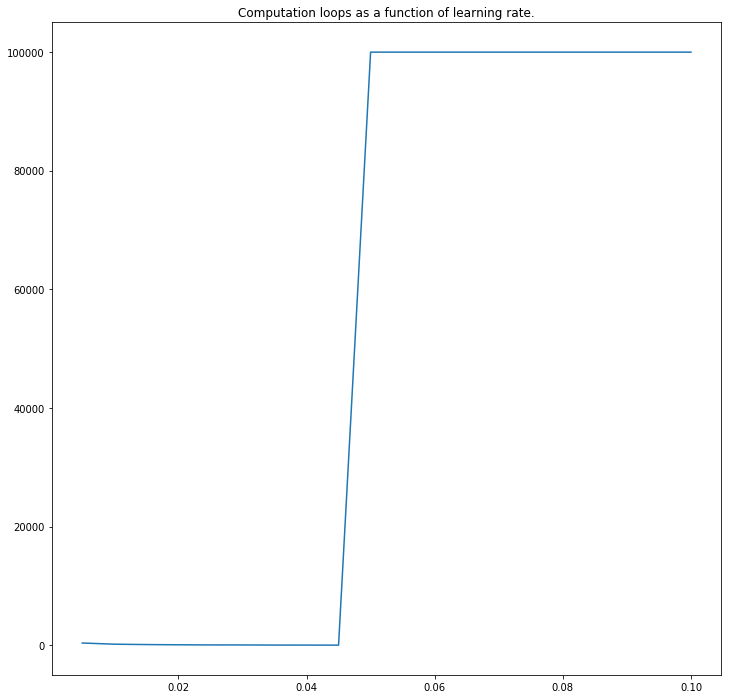

In [5]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates, results_t)
plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


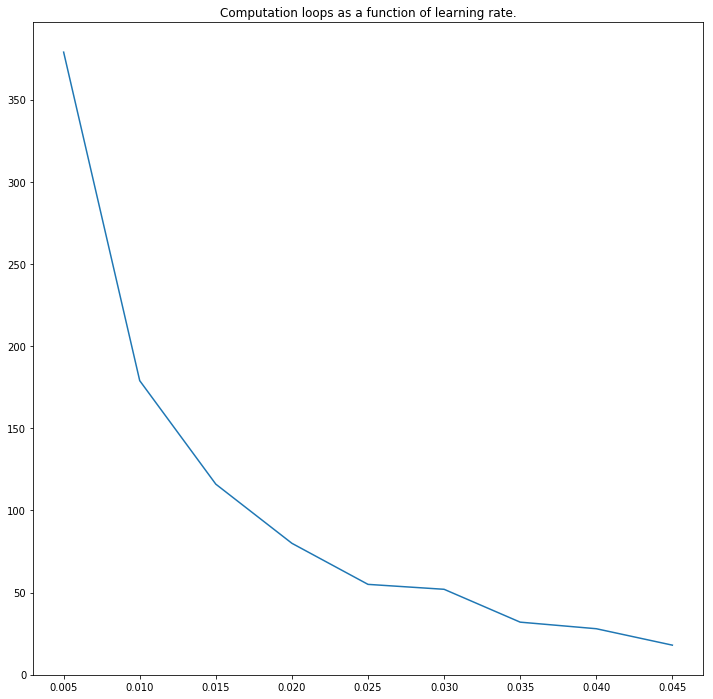

In [9]:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.plot(learning_rates[0:9], results_t[0:9])
plt.title("Computation loops as a function of learning rate.")
#plt.plot([i for i in range(1,25)], data_2[0][0])
#plt.ylabel('some numbers')
plt.show()


In [10]:
results_W[6] #Denoised

array([[0.  , 0.75, 0.75, 0.  , 0.81, 0.  , 0.52],
       [0.75, 0.  , 0.76, 0.  , 0.33, 0.  , 0.25],
       [0.75, 0.76, 0.  , 0.  , 0.89, 0.  , 0.8 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.81, 0.33, 0.89, 0.  , 0.  , 0.  , 0.76],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.52, 0.25, 0.8 , 0.  , 0.76, 0.  , 0.  ]])

In [11]:
W_t #Noisy one

array([[0.  , 0.81, 0.81, 0.  , 0.87, 0.  , 0.58],
       [0.81, 0.  , 0.82, 0.  , 0.39, 0.  , 0.31],
       [0.81, 0.82, 0.  , 0.  , 0.95, 0.  , 0.87],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.87, 0.39, 0.95, 0.  , 0.  , 0.  , 0.82],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.58, 0.31, 0.87, 0.  , 0.82, 0.  , 0.  ]])